In [ ]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

replace IAM_Words/words.tgz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!head -20 data/words.txt

In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)


2024-01-13 15:49:13.292786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [3]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [4]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [5]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [6]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

2024-01-13 15:49:22.226448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [9]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [10]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

2024-01-13 15:49:23.601742: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


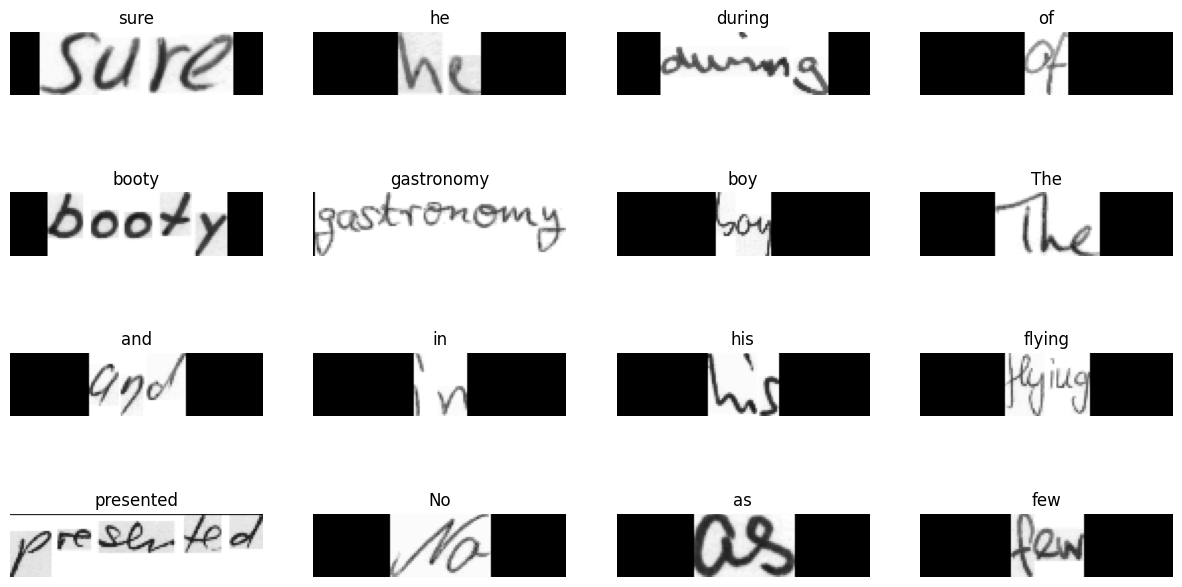

In [11]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [12]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [13]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [14]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [15]:
epochs = 100  

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/100
1/1 [==============================] - 1s 1s/step
Mean edit distance for epoch 1: 20.4731
1357/1357 [==============================] - 230s 165ms/step - loss: 13.5066 - val_loss: 11.9013
Epoch 2/100
1/1 [==============================] - 0s 44ms/step
Mean edit distance for epoch 2: 20.0978
1357/1357 [==============================] - 216s 159ms/step - loss: 10.8559 - val_loss: 9.7356


Epoch 3/100
1/1 [==============================] - 0s 41ms/step
Mean edit distance for epoch 3: 19.7656
1357/1357 [==============================] - 223s 164ms/step - loss: 9.2405 - val_loss: 8.2743
Epoch 4/100
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 4: 19.2502
1357/1357 [==============================] - 234s 172ms/step - loss: 7.7958 - val_loss: 6.6510


Epoch 5/100
1/1 [==============================] - 0s 44ms/step
Mean edit distance for epoch 5: 18.7606
1357/1357 [==============================] - 243s 179ms/step - loss: 6.5871 - val_loss: 5.5095
Epoch 6/100
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 6: 18.4165
1357/1357 [==============================] - 235s 173ms/step - loss: 5.6595 - val_loss: 4.6239


Epoch 7/100
1/1 [==============================] - 0s 60ms/step
Mean edit distance for epoch 7: 18.2261
1357/1357 [==============================] - 239s 176ms/step - loss: 5.0147 - val_loss: 4.0500
Epoch 8/100
1/1 [==============================] - 0s 42ms/step
Mean edit distance for epoch 8: 18.0081
1357/1357 [==============================] - 244s 180ms/step - loss: 4.5101 - val_loss: 3.5894


Epoch 9/100
1/1 [==============================] - 0s 41ms/step
Mean edit distance for epoch 9: 17.9119
1357/1357 [==============================] - 248s 183ms/step - loss: 4.1411 - val_loss: 3.3266
Epoch 10/100
1/1 [==============================] - 0s 42ms/step
Mean edit distance for epoch 10: 17.9691
1357/1357 [==============================] - 245s 180ms/step - loss: 3.8331 - val_loss: 3.2742


Epoch 11/100
1/1 [==============================] - 0s 36ms/step
Mean edit distance for epoch 11: 17.8117
1357/1357 [==============================] - 249s 184ms/step - loss: 3.5777 - val_loss: 2.9515
Epoch 12/100
1/1 [==============================] - 0s 46ms/step
Mean edit distance for epoch 12: 17.7739
1357/1357 [==============================] - 251s 185ms/step - loss: 3.3844 - val_loss: 2.8804


Epoch 13/100
1/1 [==============================] - 0s 53ms/step
Mean edit distance for epoch 13: 17.7286
1357/1357 [==============================] - 251s 185ms/step - loss: 3.2330 - val_loss: 2.6963
Epoch 14/100
1/1 [==============================] - 0s 44ms/step
Mean edit distance for epoch 14: 17.7215
1357/1357 [==============================] - 249s 183ms/step - loss: 3.0922 - val_loss: 2.6840


Epoch 15/100
1/1 [==============================] - 0s 46ms/step
Mean edit distance for epoch 15: 17.6382
1357/1357 [==============================] - 258s 190ms/step - loss: 2.9769 - val_loss: 2.4636
Epoch 16/100
1/1 [==============================] - 0s 47ms/step
Mean edit distance for epoch 16: 17.6179
1357/1357 [==============================] - 259s 191ms/step - loss: 2.8811 - val_loss: 2.5256


Epoch 17/100
1/1 [==============================] - 0s 50ms/step
Mean edit distance for epoch 17: 17.5494
1357/1357 [==============================] - 257s 189ms/step - loss: 2.8316 - val_loss: 2.3533
Epoch 18/100
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 18: 17.5565
1357/1357 [==============================] - 254s 187ms/step - loss: 2.6930 - val_loss: 2.3828


Epoch 19/100
1/1 [==============================] - 0s 56ms/step
Mean edit distance for epoch 19: 17.5210
1357/1357 [==============================] - 252s 186ms/step - loss: 2.6909 - val_loss: 2.2634
Epoch 20/100
1/1 [==============================] - 0s 46ms/step
Mean edit distance for epoch 20: 17.5100
1357/1357 [==============================] - 248s 183ms/step - loss: 2.5886 - val_loss: 2.1965


Epoch 21/100
1/1 [==============================] - 0s 51ms/step
Mean edit distance for epoch 21: 17.5178
1357/1357 [==============================] - 246s 181ms/step - loss: 2.5176 - val_loss: 2.1662
Epoch 22/100
1/1 [==============================] - 0s 43ms/step
Mean edit distance for epoch 22: 17.5569
1357/1357 [==============================] - 250s 184ms/step - loss: 2.4655 - val_loss: 2.3538


Epoch 23/100
1/1 [==============================] - 0s 45ms/step
Mean edit distance for epoch 23: 17.5595
1357/1357 [==============================] - 252s 185ms/step - loss: 2.4657 - val_loss: 2.5295
Epoch 24/100
1/1 [==============================] - 0s 37ms/step
Mean edit distance for epoch 24: 17.4745
1357/1357 [==============================] - 245s 180ms/step - loss: 2.4489 - val_loss: 2.0941


Epoch 25/100
1/1 [==============================] - 0s 46ms/step
Mean edit distance for epoch 25: 17.4786
1357/1357 [==============================] - 252s 186ms/step - loss: 2.3699 - val_loss: 2.2855
Epoch 26/100
1/1 [==============================] - 0s 50ms/step
Mean edit distance for epoch 26: 17.4559
1357/1357 [==============================] - 250s 184ms/step - loss: 2.3239 - val_loss: 2.0901


Epoch 27/100
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 27: 17.4472
1357/1357 [==============================] - 259s 191ms/step - loss: 2.2571 - val_loss: 2.0566
Epoch 28/100
1/1 [==============================] - 0s 51ms/step
Mean edit distance for epoch 28: 17.4263
1357/1357 [==============================] - 253s 187ms/step - loss: 2.1987 - val_loss: 2.0054


Epoch 29/100
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 29: 17.4594
1357/1357 [==============================] - 250s 185ms/step - loss: 2.1470 - val_loss: 2.0101
Epoch 30/100
1/1 [==============================] - 0s 54ms/step
Mean edit distance for epoch 30: 17.4311
1357/1357 [==============================] - 258s 190ms/step - loss: 2.1398 - val_loss: 1.9635


Epoch 31/100
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 31: 17.4019
1357/1357 [==============================] - 253s 187ms/step - loss: 2.0824 - val_loss: 1.8929
Epoch 32/100
1/1 [==============================] - 0s 59ms/step
Mean edit distance for epoch 32: 17.4024
1357/1357 [==============================] - 260s 191ms/step - loss: 2.1223 - val_loss: 1.9345


Epoch 33/100
1/1 [==============================] - 0s 44ms/step
Mean edit distance for epoch 33: 17.4038
1357/1357 [==============================] - 256s 189ms/step - loss: 2.0962 - val_loss: 1.9085
Epoch 34/100
1/1 [==============================] - 0s 52ms/step
Mean edit distance for epoch 34: 17.3995
1357/1357 [==============================] - 268s 198ms/step - loss: 2.0372 - val_loss: 1.9051


Epoch 35/100
1/1 [==============================] - 0s 47ms/step
Mean edit distance for epoch 35: 17.4073
1357/1357 [==============================] - 262s 193ms/step - loss: 1.9826 - val_loss: 1.9104
Epoch 36/100
1/1 [==============================] - 0s 59ms/step
Mean edit distance for epoch 36: 17.4151
1357/1357 [==============================] - 271s 200ms/step - loss: 1.9958 - val_loss: 1.9222


Epoch 37/100
1/1 [==============================] - 0s 44ms/step
Mean edit distance for epoch 37: 17.3843
1357/1357 [==============================] - 270s 199ms/step - loss: 1.9317 - val_loss: 1.8386
Epoch 38/100
1/1 [==============================] - 0s 39ms/step
Mean edit distance for epoch 38: 17.3651
1357/1357 [==============================] - 268s 197ms/step - loss: 1.9001 - val_loss: 1.8183


Epoch 39/100
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 39: 17.3767
1357/1357 [==============================] - 264s 195ms/step - loss: 1.9339 - val_loss: 1.8256
Epoch 40/100
1/1 [==============================] - 0s 48ms/step
Mean edit distance for epoch 40: 17.3796
1357/1357 [==============================] - 269s 198ms/step - loss: 1.8980 - val_loss: 1.8514


Epoch 41/100
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 41: 17.3511
1357/1357 [==============================] - 270s 199ms/step - loss: 1.8345 - val_loss: 1.7628
Epoch 42/100
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 42: 17.3870
1357/1357 [==============================] - 274s 202ms/step - loss: 1.8245 - val_loss: 1.8480


Epoch 43/100
1/1 [==============================] - 0s 38ms/step
Mean edit distance for epoch 43: 17.3763
1357/1357 [==============================] - 277s 204ms/step - loss: 1.7975 - val_loss: 1.8413
Epoch 44/100
1/1 [==============================] - 0s 45ms/step
Mean edit distance for epoch 44: 17.3524
1357/1357 [==============================] - 263s 194ms/step - loss: 1.7682 - val_loss: 1.7762


Epoch 45/100
1/1 [==============================] - 0s 52ms/step
Mean edit distance for epoch 45: 17.3715
1357/1357 [==============================] - 262s 193ms/step - loss: 1.7513 - val_loss: 1.7997
Epoch 46/100
1/1 [==============================] - 0s 61ms/step
Mean edit distance for epoch 46: 17.3438
1357/1357 [==============================] - 263s 194ms/step - loss: 1.7824 - val_loss: 1.7502


Epoch 47/100
1/1 [==============================] - 0s 43ms/step
Mean edit distance for epoch 47: 17.3794
1357/1357 [==============================] - 255s 188ms/step - loss: 1.7120 - val_loss: 1.8056
Epoch 48/100
1/1 [==============================] - 0s 50ms/step
Mean edit distance for epoch 48: 17.3368
1357/1357 [==============================] - 257s 190ms/step - loss: 1.7019 - val_loss: 1.7456


Epoch 49/100
1/1 [==============================] - 0s 44ms/step
Mean edit distance for epoch 49: 17.3366
1357/1357 [==============================] - 259s 191ms/step - loss: 1.6865 - val_loss: 1.7401
Epoch 50/100
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 50: 17.3214
1357/1357 [==============================] - 264s 195ms/step - loss: 1.6873 - val_loss: 1.7153


Epoch 51/100
1/1 [==============================] - 0s 44ms/step
Mean edit distance for epoch 51: 17.3344
1357/1357 [==============================] - 265s 195ms/step - loss: 1.6597 - val_loss: 1.7391
Epoch 52/100
1/1 [==============================] - 0s 52ms/step
Mean edit distance for epoch 52: 17.3328
1357/1357 [==============================] - 265s 195ms/step - loss: 1.6426 - val_loss: 1.7340


Epoch 53/100
1/1 [==============================] - 0s 67ms/step
Mean edit distance for epoch 53: 17.3245
1357/1357 [==============================] - 282s 208ms/step - loss: 1.6531 - val_loss: 1.7259
Epoch 54/100
1/1 [==============================] - 0s 55ms/step
Mean edit distance for epoch 54: 17.3720
1357/1357 [==============================] - 271s 200ms/step - loss: 1.6223 - val_loss: 1.7847


Epoch 55/100
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 55: 17.3534
1357/1357 [==============================] - 270s 199ms/step - loss: 1.6043 - val_loss: 1.7680
Epoch 56/100
1/1 [==============================] - 0s 53ms/step
Mean edit distance for epoch 56: 17.3110
1357/1357 [==============================] - 265s 196ms/step - loss: 1.5910 - val_loss: 1.7032


Epoch 57/100
1/1 [==============================] - 0s 47ms/step
Mean edit distance for epoch 57: 17.3136
1357/1357 [==============================] - 262s 193ms/step - loss: 1.5973 - val_loss: 1.7145
Epoch 58/100
1/1 [==============================] - 0s 50ms/step
Mean edit distance for epoch 58: 17.3322
1357/1357 [==============================] - 265s 196ms/step - loss: 1.5687 - val_loss: 1.7081


Epoch 59/100
1/1 [==============================] - 0s 52ms/step
Mean edit distance for epoch 59: 17.3336
1357/1357 [==============================] - 265s 195ms/step - loss: 1.5733 - val_loss: 1.7112
Epoch 60/100
1/1 [==============================] - 0s 56ms/step
Mean edit distance for epoch 60: 17.3053
1357/1357 [==============================] - 272s 200ms/step - loss: 1.5401 - val_loss: 1.6965


Epoch 61/100
1/1 [==============================] - 0s 41ms/step
Mean edit distance for epoch 61: 17.3161
1357/1357 [==============================] - 269s 198ms/step - loss: 1.5309 - val_loss: 1.6815
Epoch 62/100
1/1 [==============================] - 0s 52ms/step
Mean edit distance for epoch 62: 17.3138
1357/1357 [==============================] - 269s 198ms/step - loss: 1.5289 - val_loss: 1.7279


Epoch 63/100
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 63: 17.3136
1357/1357 [==============================] - 272s 200ms/step - loss: 1.5139 - val_loss: 1.6913
Epoch 64/100
1/1 [==============================] - 0s 42ms/step
Mean edit distance for epoch 64: 17.3059
1357/1357 [==============================] - 259s 191ms/step - loss: 1.5164 - val_loss: 1.6752


Epoch 65/100
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 65: 17.3153
1357/1357 [==============================] - 252s 186ms/step - loss: 1.4915 - val_loss: 1.6736
Epoch 66/100
1/1 [==============================] - 0s 48ms/step
Mean edit distance for epoch 66: 17.2878
1357/1357 [==============================] - 272s 200ms/step - loss: 1.5124 - val_loss: 1.6703


Epoch 67/100
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 67: 17.3092
1357/1357 [==============================] - 271s 200ms/step - loss: 1.4910 - val_loss: 1.7222
Epoch 68/100
1/1 [==============================] - 0s 46ms/step
Mean edit distance for epoch 68: 17.2948
1357/1357 [==============================] - 273s 201ms/step - loss: 1.4862 - val_loss: 1.6616


Epoch 69/100
1/1 [==============================] - 0s 54ms/step
Mean edit distance for epoch 69: 17.3019
1357/1357 [==============================] - 264s 195ms/step - loss: 1.4688 - val_loss: 1.6890
Epoch 70/100
1/1 [==============================] - 0s 61ms/step
Mean edit distance for epoch 70: 17.3130
1357/1357 [==============================] - 263s 194ms/step - loss: 1.5061 - val_loss: 1.6808


Epoch 71/100
1/1 [==============================] - 0s 41ms/step
Mean edit distance for epoch 71: 17.3072
1357/1357 [==============================] - 256s 188ms/step - loss: 1.4357 - val_loss: 1.6955
Epoch 72/100
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 72: 17.2893
1357/1357 [==============================] - 271s 200ms/step - loss: 1.4316 - val_loss: 1.6706


Epoch 73/100
1/1 [==============================] - 0s 41ms/step
Mean edit distance for epoch 73: 17.2988
1357/1357 [==============================] - 275s 203ms/step - loss: 1.4176 - val_loss: 1.7040
Epoch 74/100
1/1 [==============================] - 0s 59ms/step
Mean edit distance for epoch 74: 17.3165
1357/1357 [==============================] - 275s 203ms/step - loss: 1.4300 - val_loss: 1.7076


Epoch 75/100
1/1 [==============================] - 0s 48ms/step
Mean edit distance for epoch 75: 17.3051
1357/1357 [==============================] - 286s 211ms/step - loss: 1.4142 - val_loss: 1.6806
Epoch 76/100
1/1 [==============================] - 0s 56ms/step
Mean edit distance for epoch 76: 17.2921
1357/1357 [==============================] - 278s 205ms/step - loss: 1.4037 - val_loss: 1.6480


Epoch 77/100
1/1 [==============================] - 0s 47ms/step
Mean edit distance for epoch 77: 17.2856
1357/1357 [==============================] - 284s 209ms/step - loss: 1.3964 - val_loss: 1.6342
Epoch 78/100
1/1 [==============================] - 0s 44ms/step
Mean edit distance for epoch 78: 17.2921
1357/1357 [==============================] - 288s 212ms/step - loss: 1.3768 - val_loss: 1.7121


Epoch 79/100
1/1 [==============================] - 0s 43ms/step
Mean edit distance for epoch 79: 17.2883
1357/1357 [==============================] - 278s 205ms/step - loss: 1.3779 - val_loss: 1.6484
Epoch 80/100
1/1 [==============================] - 0s 55ms/step
Mean edit distance for epoch 80: 17.2999
1357/1357 [==============================] - 280s 206ms/step - loss: 1.3820 - val_loss: 1.6735


Epoch 81/100
1/1 [==============================] - 0s 51ms/step
Mean edit distance for epoch 81: 17.2958
1357/1357 [==============================] - 286s 211ms/step - loss: 1.3625 - val_loss: 1.6507
Epoch 82/100
1/1 [==============================] - 0s 47ms/step
Mean edit distance for epoch 82: 17.3014
1357/1357 [==============================] - 282s 208ms/step - loss: 1.3636 - val_loss: 1.6703


Epoch 83/100
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 83: 17.2995
1357/1357 [==============================] - 276s 203ms/step - loss: 1.3512 - val_loss: 1.6894
Epoch 84/100
1/1 [==============================] - 0s 43ms/step
Mean edit distance for epoch 84: 17.2940
1357/1357 [==============================] - 277s 204ms/step - loss: 1.3474 - val_loss: 1.6569


Epoch 85/100
1/1 [==============================] - 0s 41ms/step
Mean edit distance for epoch 85: 17.3144
1357/1357 [==============================] - 282s 208ms/step - loss: 1.3383 - val_loss: 1.6915
Epoch 86/100
1/1 [==============================] - 0s 48ms/step
Mean edit distance for epoch 86: 17.3101
1357/1357 [==============================] - 280s 207ms/step - loss: 1.3311 - val_loss: 1.6886


Epoch 87/100
1/1 [==============================] - 0s 41ms/step
Mean edit distance for epoch 87: 17.3079
1357/1357 [==============================] - 282s 208ms/step - loss: 1.3226 - val_loss: 1.6837
Epoch 88/100
1/1 [==============================] - 0s 56ms/step
Mean edit distance for epoch 88: 17.2924
1357/1357 [==============================] - 282s 208ms/step - loss: 1.3314 - val_loss: 1.6689


Epoch 89/100
1/1 [==============================] - 0s 59ms/step
Mean edit distance for epoch 89: 17.2821
1357/1357 [==============================] - 283s 209ms/step - loss: 1.3194 - val_loss: 1.6411
Epoch 90/100
1/1 [==============================] - 0s 43ms/step
Mean edit distance for epoch 90: 17.2850
1357/1357 [==============================] - 287s 212ms/step - loss: 1.3208 - val_loss: 1.6429


Epoch 91/100
1/1 [==============================] - 0s 47ms/step
Mean edit distance for epoch 91: 17.2941
1357/1357 [==============================] - 280s 207ms/step - loss: 1.3072 - val_loss: 1.6585
Epoch 92/100
1/1 [==============================] - 0s 65ms/step
Mean edit distance for epoch 92: 17.2773
1357/1357 [==============================] - 286s 211ms/step - loss: 1.2945 - val_loss: 1.6413


Epoch 93/100
1/1 [==============================] - 0s 38ms/step
Mean edit distance for epoch 93: 17.3010
1357/1357 [==============================] - 284s 209ms/step - loss: 1.3015 - val_loss: 1.6822
Epoch 94/100
1/1 [==============================] - 0s 50ms/step
Mean edit distance for epoch 94: 17.2966
1357/1357 [==============================] - 283s 209ms/step - loss: 1.2883 - val_loss: 1.6380


Epoch 95/100
1/1 [==============================] - 0s 61ms/step
Mean edit distance for epoch 95: 17.3059
1357/1357 [==============================] - 278s 205ms/step - loss: 1.2821 - val_loss: 1.6705
Epoch 96/100
1/1 [==============================] - 0s 52ms/step
Mean edit distance for epoch 96: 17.2828
1357/1357 [==============================] - 281s 207ms/step - loss: 1.2948 - val_loss: 1.6043


Epoch 97/100
1/1 [==============================] - 0s 48ms/step
Mean edit distance for epoch 97: 17.2830
1357/1357 [==============================] - 275s 202ms/step - loss: 1.2822 - val_loss: 1.6283
Epoch 98/100
1/1 [==============================] - 0s 48ms/step
Mean edit distance for epoch 98: 17.3091
1357/1357 [==============================] - 283s 209ms/step - loss: 1.2620 - val_loss: 1.6925


Epoch 99/100
1/1 [==============================] - 0s 48ms/step
Mean edit distance for epoch 99: 17.2808
1357/1357 [==============================] - 280s 207ms/step - loss: 1.2736 - val_loss: 1.6124
Epoch 100/100
1/1 [==============================] - 0s 45ms/step
Mean edit distance for epoch 100: 17.3007
1357/1357 [==============================] - 279s 206ms/step - loss: 1.2737 - val_loss: 1.6414


2024-01-13 23:09:56.992693: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2/2 [==============================] - 0s 41ms/step


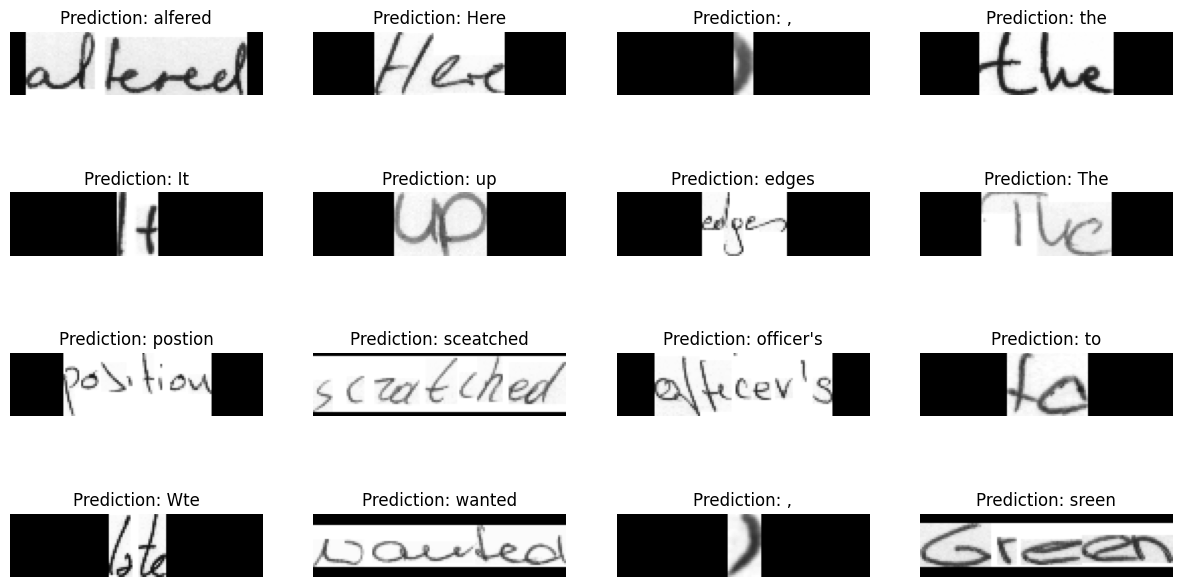

In [16]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

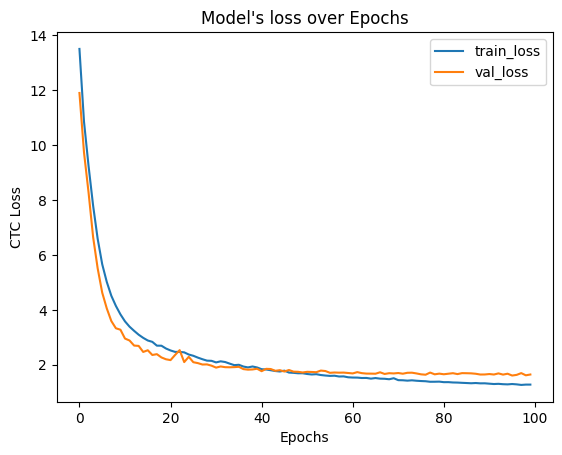

In [17]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("CTC Loss")
plt.title("Model's loss over Epochs")
plt.legend()
plt.show()

In [18]:
prediction_model.save('model2pred.keras')

In [20]:
import tf2onnx

onnx_model, _ = tf2onnx.convert.from_keras(prediction_model)
with open("modelG.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


2024-01-13 23:09:59.856195: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-01-13 23:09:59.856269: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-01-13 23:10:00.626194: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-01-13 23:10:00.626299: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


In [22]:
import onnxruntime

onnx_model_path = 'model.onnx'
ort_session = onnxruntime.InferenceSession(onnx_model_path)

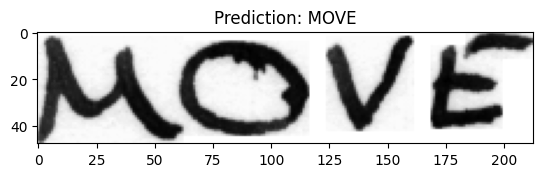

In [24]:
import cv2

input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

image_path_to_test = 'data/words/a01/a01-000u/a01-000u-00-01.png'
input_image = preprocess_image(image_path_to_test)
input_data = np.expand_dims(input_image, axis=0)

# Run inference
ort_result = ort_session.run([output_name], {input_name: input_data})

# Post-process the result
decoded_result = decode_batch_predictions(ort_result[0])

img = cv2.imread(image_path_to_test, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title(f'Prediction: {decoded_result[0]}')
plt.show()

In [27]:
print(ort_result[0][0])

[[5.85168917e-14 2.06461098e-11 1.35876621e-06 ... 1.17188094e-07
  1.30306424e-13 1.05117040e-04]
 [3.49753127e-20 2.43413425e-15 1.18636359e-11 ... 8.10978549e-14
  5.78769874e-20 9.99961853e-01]
 [5.44722402e-23 2.35830807e-15 9.62792671e-14 ... 2.78077773e-17
  8.36089313e-23 9.99999881e-01]
 ...
 [1.48504066e-18 1.61965602e-13 2.30741780e-11 ... 8.05447861e-11
  1.84669002e-18 9.99928236e-01]
 [1.85889393e-14 2.40971947e-11 8.88642671e-09 ... 2.28161379e-09
  2.15365818e-14 9.63075817e-01]
 [1.10159237e-13 3.23546367e-09 6.24419982e-08 ... 5.44966525e-08
  1.08708175e-13 2.24096424e-04]]
